In [1]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping




2025-02-08 20:23:20.968711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739042600.981530   39265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739042600.985465   39265 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 20:23:20.998927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

sns.set_style('darkgrid')

In [ ]:


extract_path = "data2"  # Where to extract files

# # Set correct paths after extraction
train_dir = os.path.join(extract_path, "train")  
test_dir = os.path.join(extract_path, "test")

# Get file names and labels
filenames = os.listdir(train_dir)
labels = [x.split(".")[0] for x in filenames]  # Adjust if your filenames are different

# Create DataFrame
df = pd.DataFrame({
    "filepaths": [os.path.join(train_dir, f) for f in filenames],  
    "labels": labels
})

print(df.head())  # Display the first few rows
print(train_dir)

                                           filepaths labels
0  /mnt/c/Users/ogo13/Documents/Coding/MLProjects...    cat
1  /mnt/c/Users/ogo13/Documents/Coding/MLProjects...    cat
2  /mnt/c/Users/ogo13/Documents/Coding/MLProjects...    cat
3  /mnt/c/Users/ogo13/Documents/Coding/MLProjects...    cat
4  /mnt/c/Users/ogo13/Documents/Coding/MLProjects...    cat
/mnt/c/Users/ogo13/Documents/Coding/MLProjects2025/cat-dog-clf/data2/train


In [ ]:
# train test split using dataframe
labels = df['labels']
X_train, X_val = train_test_split(df, test_size=0.2, stratify=labels, random_state = 42)
print('The shape of train data',X_train.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (20000, 2)
The shape of validation data (5000, 2)


In [ ]:
labels = ['cat','dog']

label1,count1 = np.unique(X_train.labels,return_counts=True)
label2,count2 = np.unique(X_val.labels,return_counts=True)

print("train", label1, count1)
print("val", label2, count2)

train ['cat' 'dog'] [10000 10000]
val ['cat' 'dog'] [2500 2500]


Dataprep

In [10]:
# parameters
image_size = 128 # image size 128x128
image_channel = 3 # color channels
bat_size = 15 # batchsize

In [ ]:


train_datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=15,
                            shear_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True)
train_generator = train_datagen.flow_from_dataframe(X_train,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=(image_size, image_size),
                                       color_mode='rgb',
                                       class_mode='categorical' ,
                                       batch_size=bat_size)


test_datagen =  ImageDataGenerator(rescale=1./255,
                            rotation_range=15,
                            shear_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True)

val_datagen =  ImageDataGenerator(rescale=1./255,
                            rotation_range=15,
                            shear_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True)

val_generator = val_datagen.flow_from_dataframe(X_val,
                                      x_col='filepaths',
                                      y_col='labels',
                                       target_size=(image_size, image_size),
                                      color_mode='rgb',
                                      class_mode='categorical',
                                      batch_size=32)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(image_size, image_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')  # Binary classification (cats vs dogs)
])
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

/home/ogo13/coding/cat-dog/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739042670.161519   39265 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,800,322 (6.87 MB)

 Trainable params: 1,749,698 (6.67 MB)

 Non-trainable params: 50,624 (197.75 KB)

In [ ]:

CALLBACKS = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=2, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.01, restore_best_weights=True, verbose=1)
]


In [ ]:
steps_per_epoch = len(train_generator) 
validation_steps = len(val_generator)

In [ ]:

epochs = 30
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator,
                    batch_size=bat_size,
                    callbacks=CALLBACKS,
                    validation_steps=validation_steps,
                    steps_per_epoch=steps_per_epoch
                    )

Epoch 1/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 209s 157ms/step - accuracy: 0.7586 - loss: 0.5004 - val_accuracy: 0.7750 - val_loss: 0.4804 - learning_rate: 1.0000e-09
Epoch 2/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 256s 192ms/step - accuracy: 0.7445 - loss: 0.5173 - val_accuracy: 0.7718 - val_loss: 0.4848 - learning_rate: 1.0000e-09
Epoch 3/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7524 - loss: 0.5083
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 195s 146ms/step - accuracy: 0.7524 - loss: 0.5083 - val_accuracy: 0.7756 - val_loss: 0.4790 - learning_rate: 1.0000e-09
Epoch 4/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 160s 120ms/step - accuracy: 0.7514 - loss: 0.5068 - val_accuracy: 0.7708 - val_loss: 0.4814 - learning_rate: 1.0000e-10
Epoch 5/30
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7522 - loss: 0.5100
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-10.
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 158s 118ms/step -

In [1]:
model.save_weights("model.h5")

NameError: name 'model' is not defined

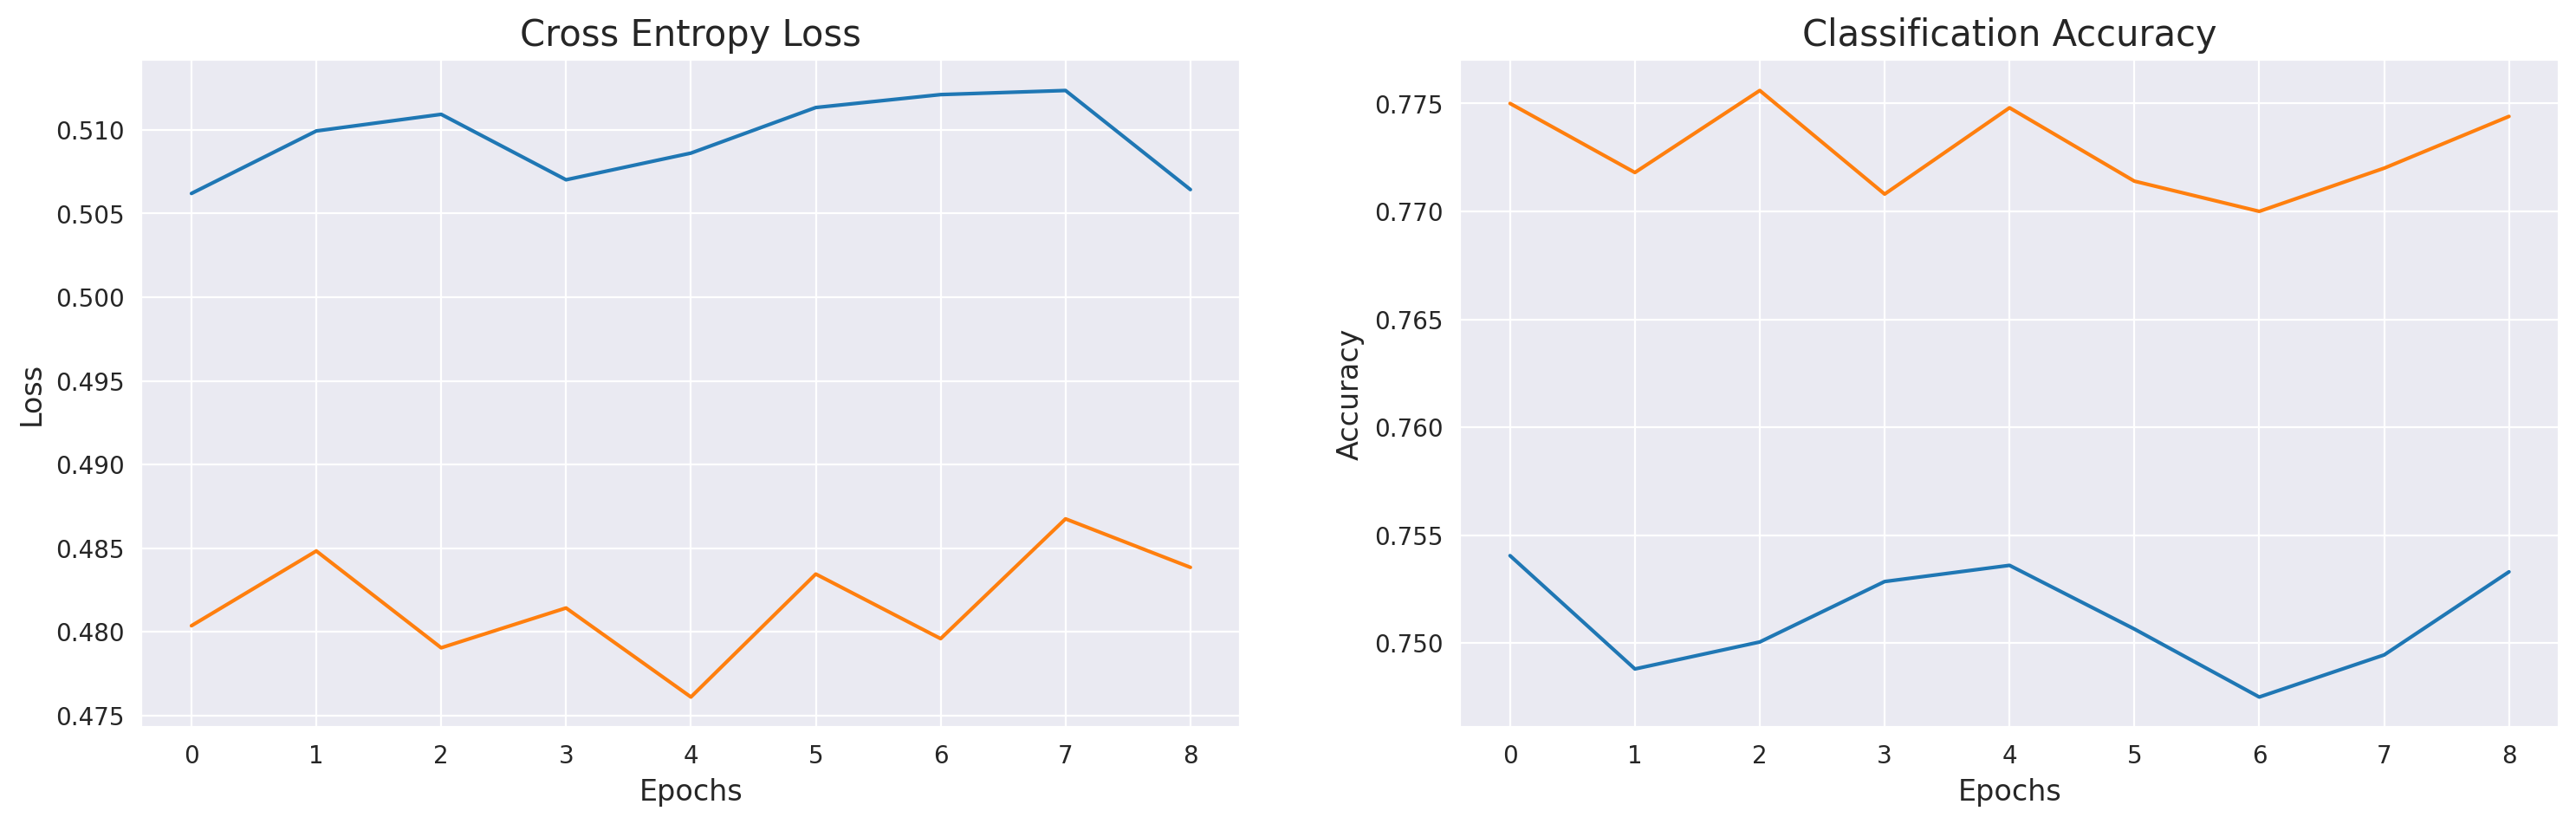

In [27]:


# plots for accuracy and Loss with epochs

error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()



In [29]:
preds = model.predict(train_generator)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels
print(preds)

1334/1334 ━━━━━━━━━━━━━━━━━━━━ 144s 108ms/step
[[0.8259102  0.17408983]
 [0.11714564 0.88285434]
 [0.2958466  0.70415336]
 ...
 [0.22475827 0.77524173]
 [0.41909045 0.58090955]
 [0.4275108  0.57248914]]


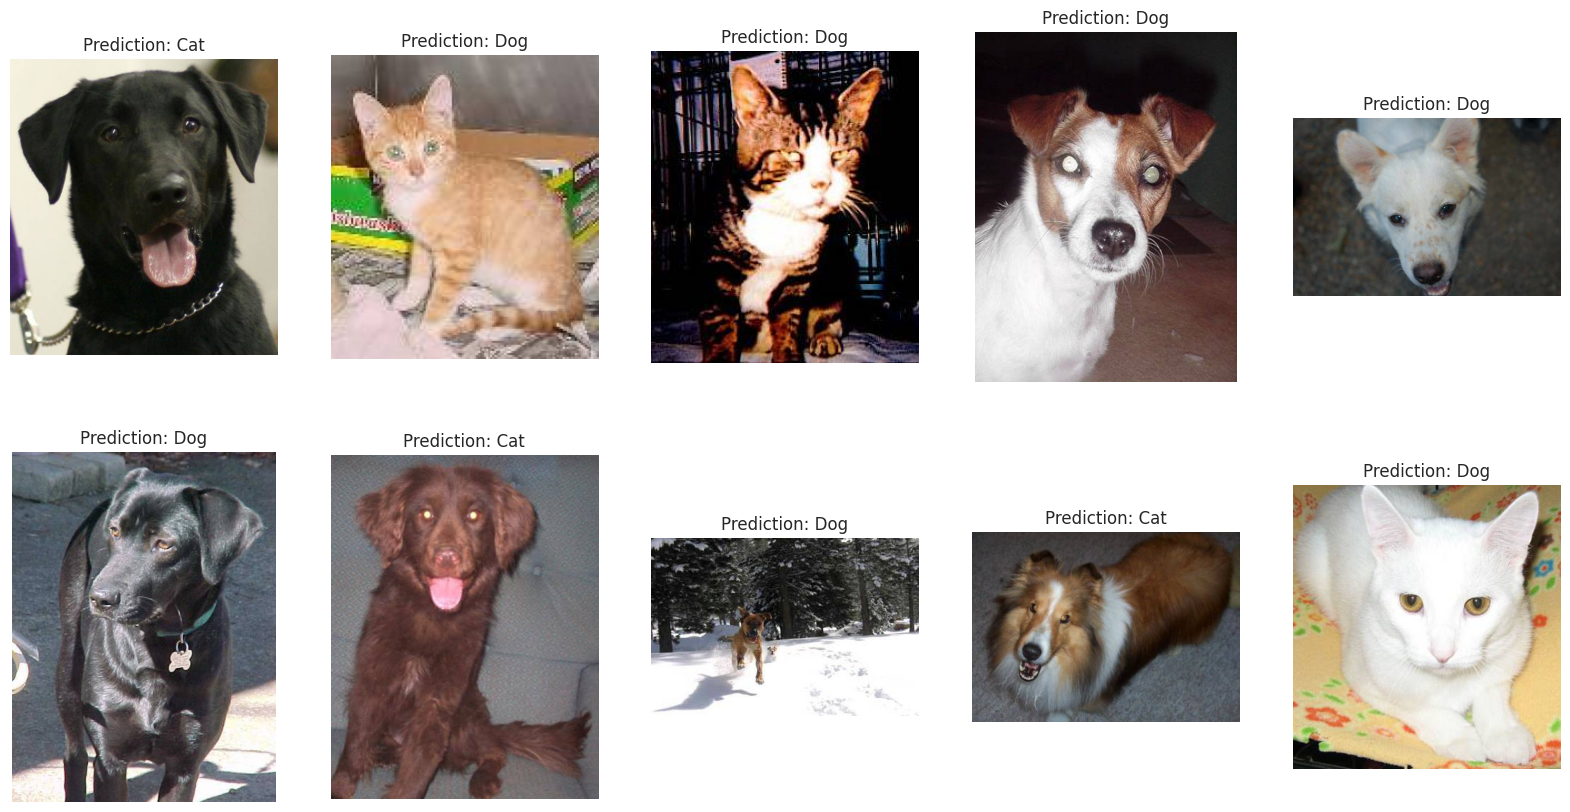

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = {0: "Cat", 1: "Dog"}

# Get predictions
# preds = model.predict(train_generator)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Get the correct filenames in the order used by the generator
ordered_filenames = [train_generator.filenames[i] for i in train_generator.index_array]

# Plot images with predictions (limit to 10 images)
num_images = min(len(ordered_filenames), 10)

plt.figure(figsize=(20, 10))
for i in range(num_images):
    img_path = ordered_filenames[i]  # Correctly ordered image path
    img = plt.imread(img_path)  # Read image

    plt.subplot(2, 5, i + 1)  # Create subplot (2 rows, 5 columns)
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[y_pred[i]]}", fontsize=12)  # Show class name
    plt.axis("off")

plt.show()


In [ ]:
# test_score = model.evaluate(test_gen)

NameError: name 'test_gen' is not defined

1/1 [==============================] - 0s 152ms/step


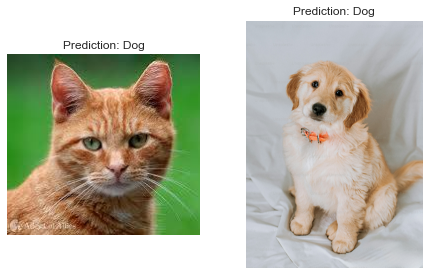

In [ ]:
# # Define class names
# class_names = {0: "Cat", 1: "Dog"}

# # Get predictions
# preds = model.predict(test_gen)
# y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# # Get the filenames from the generator
# filenames = test_gen.filenames  # List of image file paths
# num_images = min(len(filenames), 10)  # Limit to 10 images for display

# # Plot images with predictions
# plt.figure(figsize=(20, 10))
# for i in range(num_images):
#     img_path = filenames[i]  # Get image path
#     img = plt.imread(img_path)  # Read image

#     plt.subplot(2, 5, i + 1)  # Create subplot (2 rows, 5 columns)
#     plt.imshow(img)
#     plt.title(f"Prediction: {class_names[y_pred[i]]}", fontsize=12)  # Show class name
#     plt.axis("off")

# plt.show()

38/38 [==============================] - 4s 105ms/step


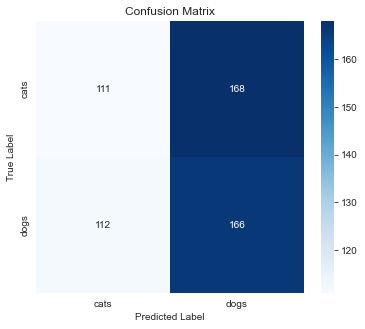

In [ ]:
# Get true labels from the test generator
y_true = train_generator.classes  # Correct way to access true labels

# Get predicted labels
preds = model.predict(train_generator)
y_pred = np.argmax(preds, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels from the generator
class_names = list(train_generator.class_indices.keys())  # Extract class names

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()